In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100

In [36]:
from collections import Counter

import tqdm
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, gaussian_kde
from sklearn.decomposition import PCA

In [3]:
from exoabc import Simulator, data

In [4]:
period_range = (50, 300)
prad_range = (0.75, 2.5)
depth_range = (0, 1000)
maxn = 2

In [5]:
prefix = "q1_q16"
stlr = data.get_burke_gk(prefix=prefix)
kois = data.get_candidates(stlr=stlr, prefix=prefix)

In [6]:
sim = Simulator(
    stlr,
    period_range[0], period_range[1], 0.0,
    prad_range[0], prad_range[1], -2.0,
    -3.0, np.zeros(maxn),
    release=prefix
)

In [7]:
def compute_stats(catalog):
    m = (period_range[0] <= catalog.koi_period) & (catalog.koi_period <= period_range[1])
    m &= (prad_range[0] <= catalog.koi_prad) & (catalog.koi_prad <= prad_range[1])
    m &= (depth_range[0] <= catalog.koi_depth) & (catalog.koi_depth <= depth_range[1])
    c = catalog[m]
    
    # Multiplicity
    h = Counter(Counter(c.kepid).values())
    hist = np.zeros(maxn, dtype=int)
    for i in range(maxn):
        hist[i] = h.get(i + 1, 0)
    
    return hist, np.array(c.koi_period), np.array(c.koi_depth), np.array(c.koi_duration)

def compute_distances(ds1, ds2):
    norm = max(np.max(ds1[0]), np.max(ds2[0]))
    multi_dist = np.sum((ds1[0] - ds2[0])**2.0) / norm**2
    period_dist = ks_2samp(ds1[1], ds2[1]).statistic
    depth_dist = ks_2samp(ds1[2], ds2[2]).statistic
    
    return multi_dist, period_dist, depth_dist

In [8]:
obs_stats = compute_stats(kois)

In [249]:
def sample(initial=None):
    if initial is None:
        lp = sim.sample_parameters()
        if not np.isfinite(lp):
            return (np.inf, np.inf, np.inf), sim.get_parameters(), sim.state
    else:
        lp = sim.set_parameters(initial)
        if not np.isfinite(lp):
            return (np.inf, np.inf, np.inf), sim.get_parameters(), sim.state

    pars, state = sim.get_parameters(), sim.state
    df = sim.sample_population()
    if len(df) <= 1:
        return (np.inf, np.inf, np.inf), pars, state
    return compute_distances(obs_stats, compute_stats(df)), pars, state

In [10]:
n = 10000
samples = [sample() for _ in tqdm.tqdm(range(n), total=n)]

In [11]:
distances = np.array([s[0] for s in samples])
m = np.all(np.isfinite(distances), axis=1)
distances = distances[m]
params = np.array([s[1] for s in samples])[m]
states = np.array([s[2] for s in samples])[m]

In [12]:
print(distances)

[[ 0.54132653  0.54073087  0.33193757]
 [ 0.          0.47887324  0.16197183]
 [ 0.28784922  0.33580191  0.16029078]
 ..., 
 [ 0.14882653  0.07844743  0.09564363]
 [ 0.16005102  0.30197854  0.13028169]
 [ 0.08163265  0.27905819  0.12832551]]


In [14]:
model = PCA(1)
model.fit(distances)

PCA(copy=True, n_components=1, whiten=False)

In [15]:
model.components_

array([[-0.92440859, -0.30361515, -0.23083892]])

In [16]:
w = np.abs(model.components_[0])
w /= np.sum(w)
scalar = np.dot(distances, w)

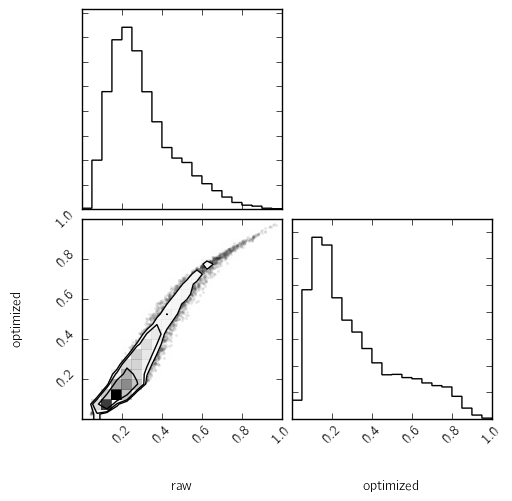

In [17]:
points = np.vstack([np.sum(distances, axis=1) / 3.0, scalar]).T
corner.corner(points, range=[(0, 1), (0, 1)], labels=["raw", "optimized"]);

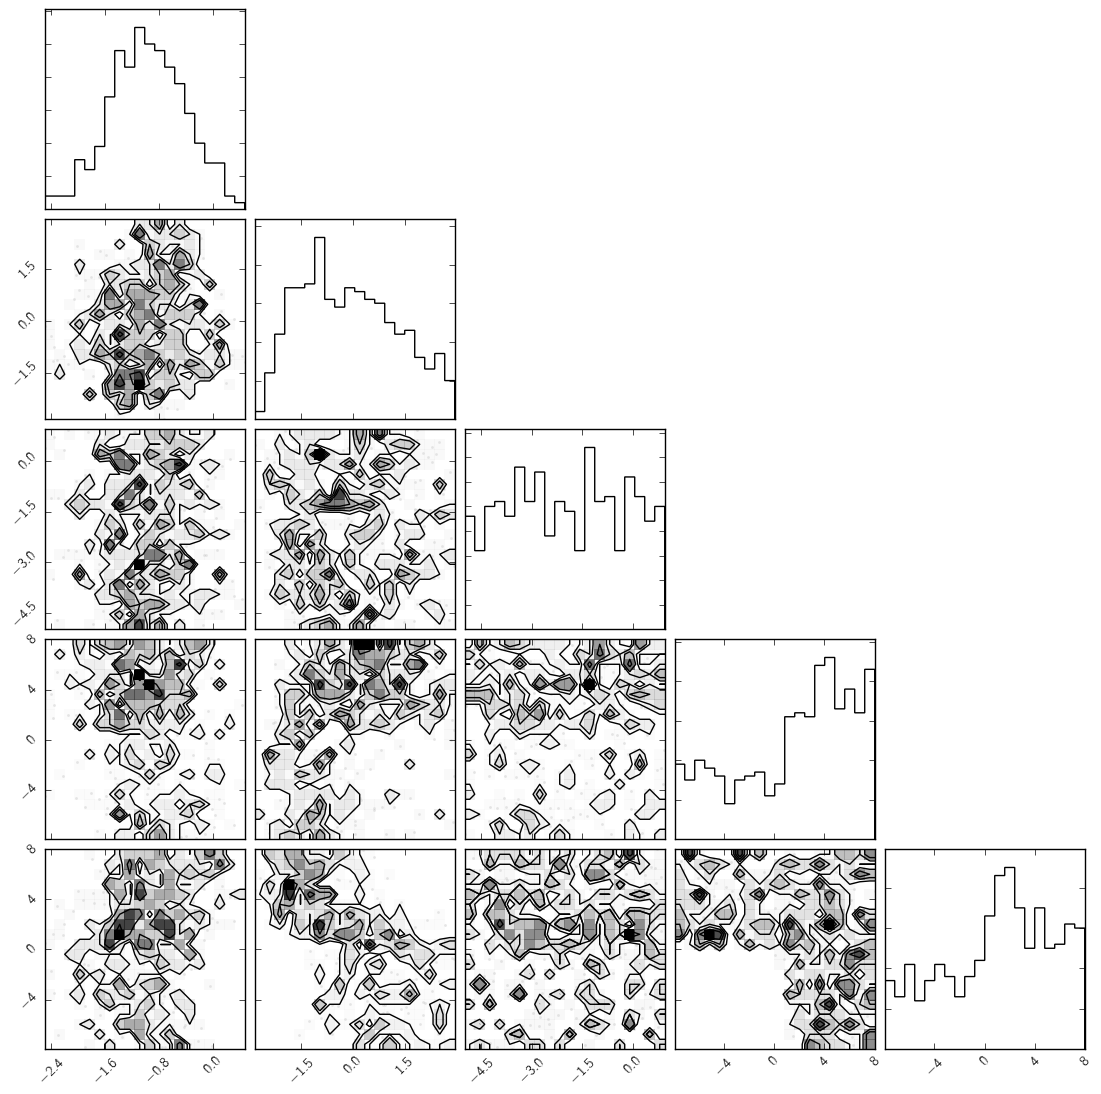

In [18]:
inds = np.argsort(scalar)
corner.corner(params[inds[:500]]);

In [160]:
i = 1
p = np.array(new_params[new_inds[i]])
print(p)

sim.set_parameters(p)
sim.state = new_states[new_inds[i]]
pop = sim.sample_population()
sim_stats = compute_stats(pop)
sim_stats[0], obs_stats[0]

[-0.73528357 -1.71238351 -2.83952317 -4.46655173  3.69641815]


(array([137,   1]), array([140,   1]))

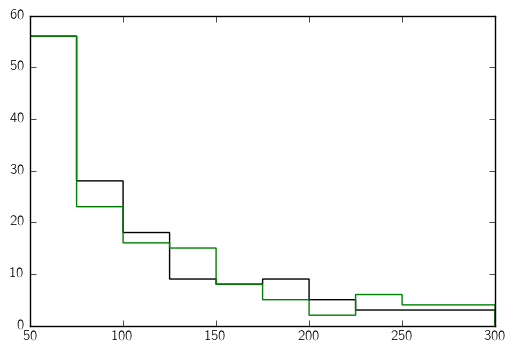

In [161]:
plt.hist(obs_stats[1], range=period_range, histtype="step", color="k")
plt.hist(sim_stats[1], range=period_range, histtype="step", color="g");

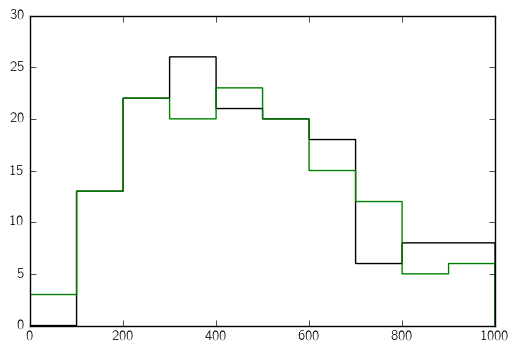

In [162]:
plt.hist(obs_stats[2], range=depth_range, histtype="step", color="k")
plt.hist(sim_stats[2], range=depth_range, histtype="step", color="g");

In [178]:
kde = gaussian_kde(new_params[new_inds].T)
#kde.factor *= 2

In [179]:
new_n = 50000
new_x = kde.resample(new_n)
new_logpdfs = kde.logpdf(new_x)

In [180]:
new_samples = [sample(x) for x in tqdm.tqdm(new_x.T, total=new_n)]

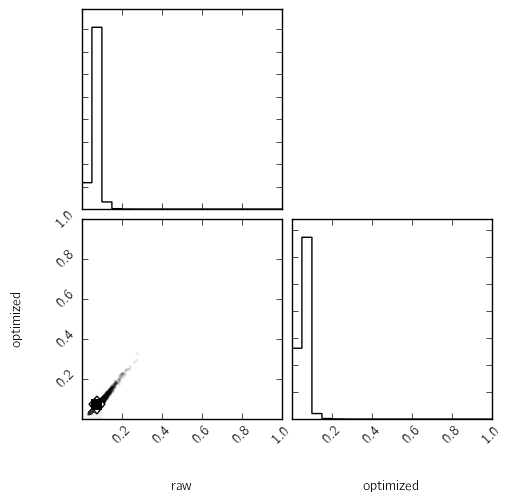

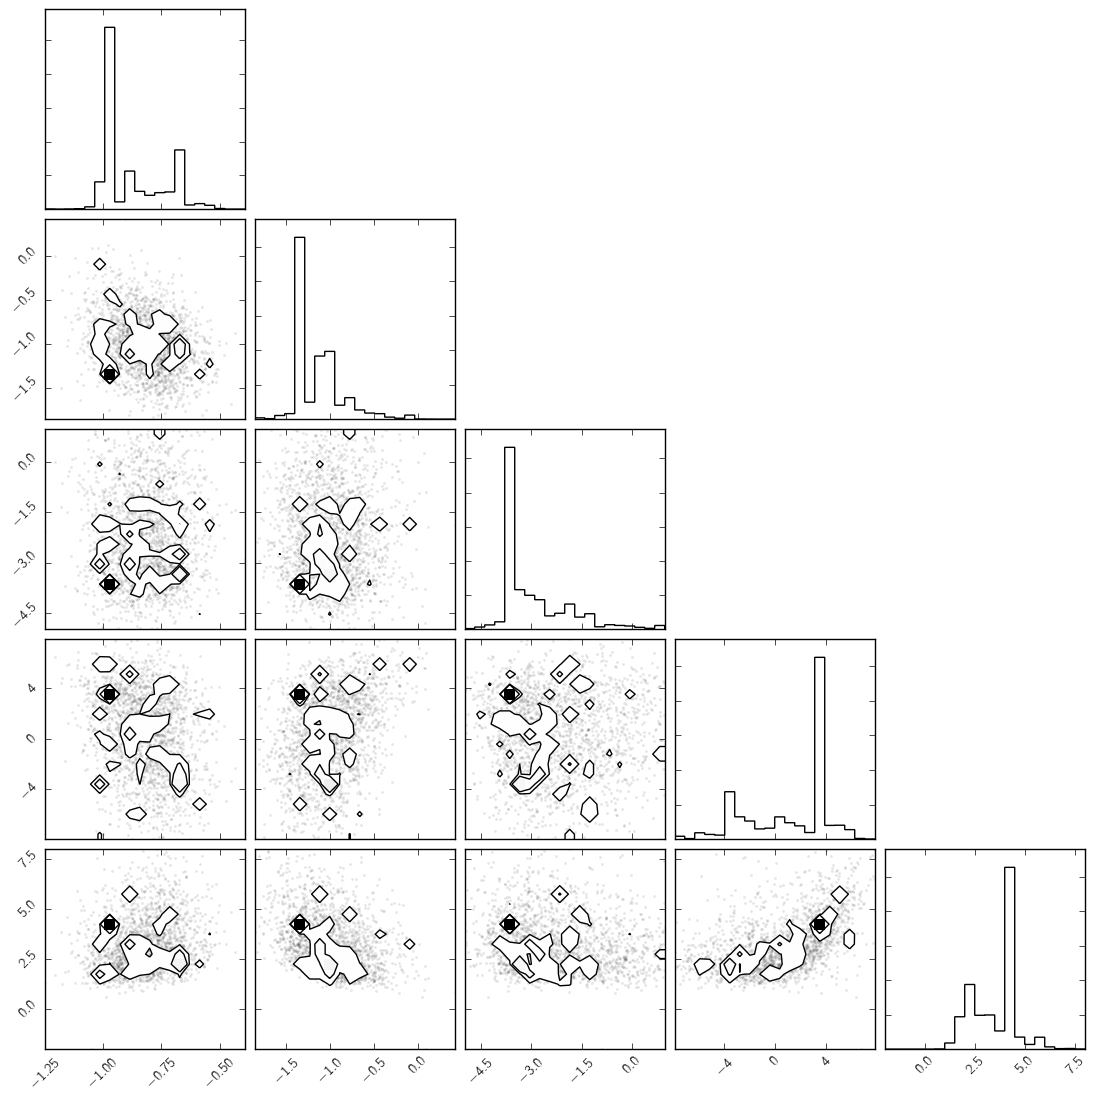

In [190]:
new_distances = np.array([s[0] for s in new_samples])
m = np.all(np.isfinite(new_distances), axis=1)
new_distances = new_distances[m]
new_params = np.array([s[1] for s in new_samples])[m]
new_states = np.array([s[2] for s in new_samples])[m]

new_model = PCA(1)
new_model.fit(new_distances)

new_w = np.abs(new_model.components_[0])
new_w /= np.sum(new_w)
new_scalar = np.dot(new_distances, new_w)

points = np.vstack([np.sum(new_distances, axis=1) / 3.0, new_scalar]).T
corner.corner(points, range=[(0, 1), (0, 1)], labels=["raw", "optimized"]);

new_inds = np.argsort(new_scalar)[:2000]
weights = new_logpdfs[new_inds]
weights = np.exp(np.min(weights) - weights)
# weights = None
corner.corner(new_params[new_inds], weights=weights);

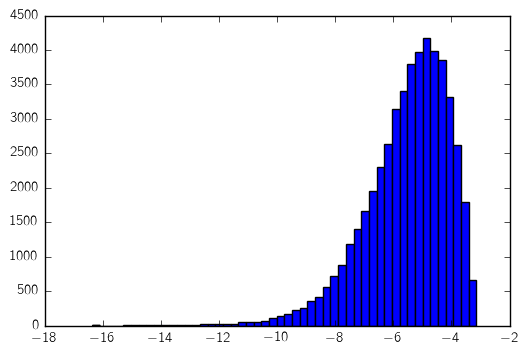

In [191]:
plt.hist(new_logpdfs, 50); # - np.max(new_logpdfs)

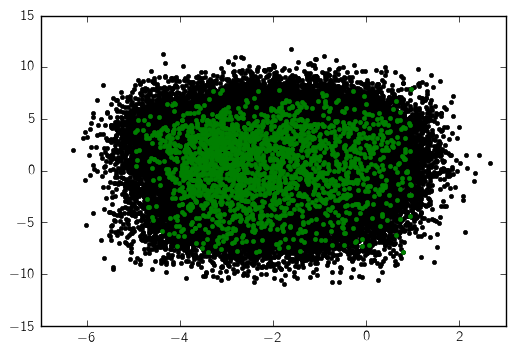

In [192]:
plt.plot(new_x[2], new_x[3], ".k")
x = new_params[new_inds]
plt.plot(x[:, 2], x[:, 3], ".g")

In [205]:
new_model = PCA(1)
new_model.fit(new_distances)
w = np.abs(new_model.components_[0])
print(w / np.sum(w))

_, ev = np.linalg.eig(np.cov(new_distances, rowvar=False))
w = np.abs(ev[:, 0])
print(w / np.sum(w))

[ 0.43127316  0.33720027  0.23152658]
[ 0.43127316  0.33720027  0.23152658]


In [206]:
np.linalg.svd(np.cov(new_distances, rowvar=False))

(array([[-0.72556691,  0.60172501,  0.33388572],
        [-0.56730022, -0.24838756, -0.78515864],
        [-0.38951653, -0.75909857,  0.52158052]]),
 array([ 0.00082769,  0.00074678,  0.00073729]),
 array([[-0.72556691, -0.56730022, -0.38951653],
        [ 0.60172501, -0.24838756, -0.75909857],
        [ 0.33388572, -0.78515864,  0.52158052]]))

In [207]:
ev

array([[ 0.72556691,  0.60172501,  0.33388572],
       [ 0.56730022, -0.24838756, -0.78515864],
       [ 0.38951653, -0.75909857,  0.52158052]])

In [216]:
def fit_distances(distances):
    _, ev = np.linalg.eig(np.cov(distances, rowvar=False))
    w = np.abs(ev[:, 0])
    w /= np.sum(w)
    print(w)
    return np.dot(distances, w)

In [217]:
fit_distances(new_distances).max()

[ 0.43127316  0.33720027  0.23152658]


0.32805194637736179

In [222]:
# iteration 1
N = 1000
theta = list(map(sample, tqdm.tqdm((None for _ in range(N)), total=N)))
distances = np.array([s[0] for s in samples])
m = np.all(np.isfinite(distances), axis=1)
distances = distances[m]
params = np.array([s[1] for s in samples])[m]
states = np.array([s[2] for s in samples])[m]
rho = np.sum(distances, axis=1)

In [223]:
rho

array([ 1.41399497,  0.64084507,  0.7839419 , ...,  0.32291759,
        0.59231125,  0.48901635])

In [252]:
tau = np.sqrt(2*np.var(params, axis=0))
eps = np.percentile(rho, 50)
weights = np.ones(len(params)) / len(params)

In [290]:
def pmc_sample_one(eps, theta0, weights, tau):
    rho = np.inf
    while rho > eps or not np.isfinite(rho):
        theta_star = theta0[np.random.choice(np.arange(len(weights)), p=weights)]
        theta_i = theta_star + tau * np.random.randn(len(theta_star))
        p, _, state = sample(theta_i)
        rho = np.sum(p)
    
    log_prior = sim.log_pdf()
    log_weight = np.log(weights) - np.sum(0.5*((theta0 - theta_i)/tau[None, :])**2 + np.log(tau[None, :]), axis=1)
    log_weight = log_prior - np.logaddexp.reduce(log_weight)
    return theta_i, rho, log_prior, log_weight

In [292]:
new_samples = [pmc_sample_one(eps, params, weights, tau) for _ in tqdm.tqdm(range(N), total=N)]

In [296]:
rho = np.array([s[1] for s in new_samples])
m = np.isfinite(rho)
rho = rho[m]
params = np.array([s[0] for s in new_samples])[m]
log_weight = np.array([s[3] for s in new_samples])[m]

(array([ 150.,  287.,  246.,  165.,   85.,   36.,   16.,   10.,    2.,    3.]),
 array([ 0.03304162,  0.04430958,  0.05557754,  0.0668455 ,  0.07811346,
         0.08938142,  0.10064938,  0.11191734,  0.1231853 ,  0.13445326,
         0.14572123]),
 <a list of 10 Patch objects>)

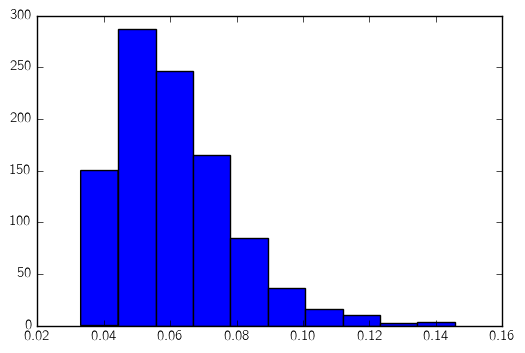

In [297]:
plt.hist(np.exp(log_weight))

In [326]:
norm = np.sum(weights)
mu = np.sum(params * weights[:, None], axis=0) / norm
np.sqrt(2 * np.sum((params - mu)**2 * weights[:, None], axis=0) / norm), tau

(array([ 0.59713739,  1.46000635,  2.27346253,  5.98294175,  5.39294517]),
 array([ 0.87059977,  1.75613841,  2.2552407 ,  5.79406228,  5.74521964]))

In [318]:
tau = np.sqrt(2*np.var(params, axis=0))
eps = np.percentile(rho, 50)
weights = np.exp(log_weight - np.logaddexp.reduce(log_weight))

In [319]:
new_samples_2 = [pmc_sample_one(eps, params, weights, tau) for _ in tqdm.tqdm(range(N), total=N)]

In [320]:
rho = np.array([s[1] for s in new_samples_2])
m = np.isfinite(rho)
rho = rho[m]
params = np.array([s[0] for s in new_samples_2])[m]
log_weights = np.array([s[3] for s in new_samples_2])[m]

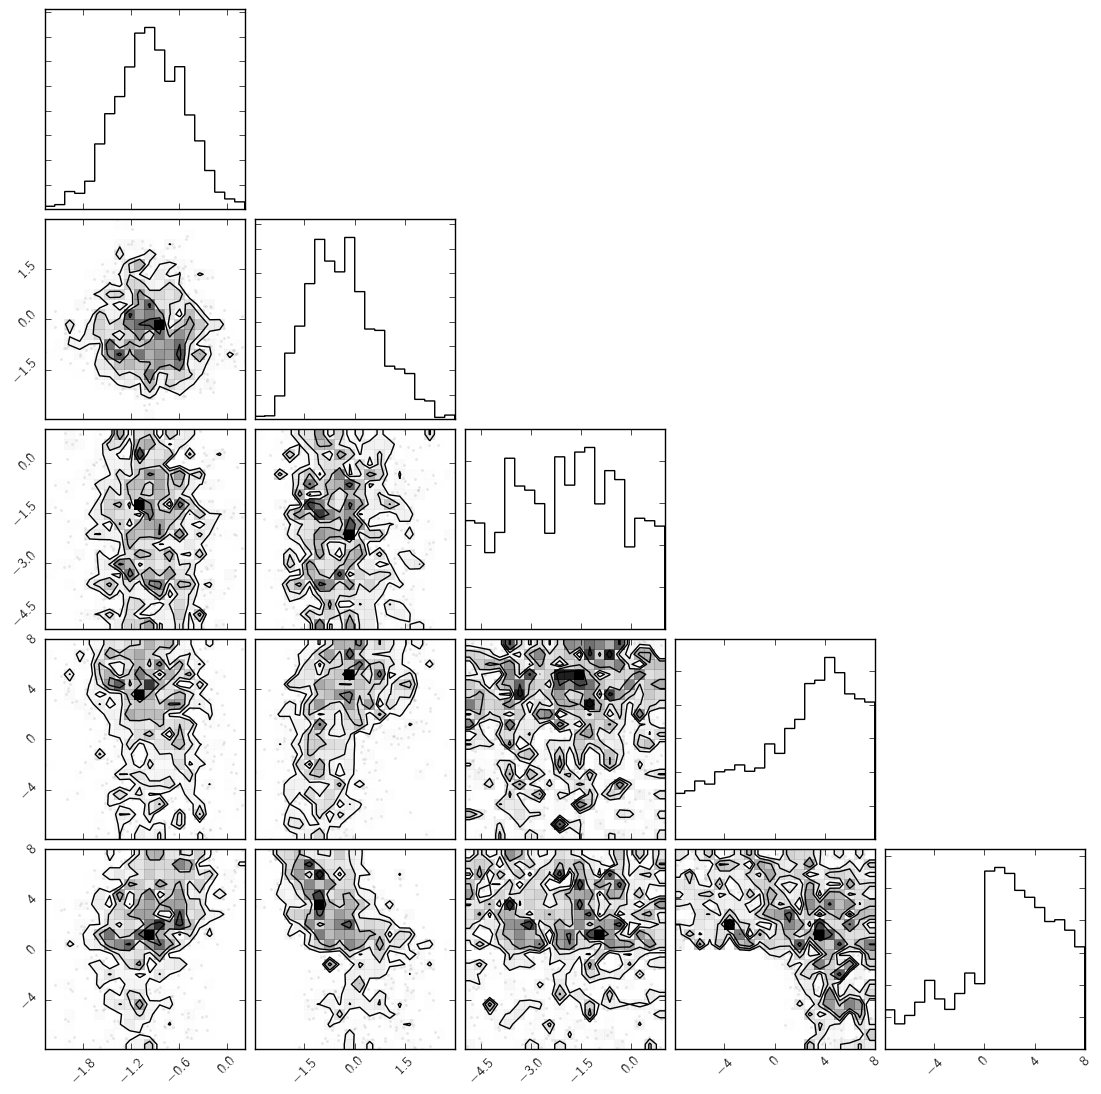

In [321]:
corner.corner(params, weights=np.exp(log_weight));

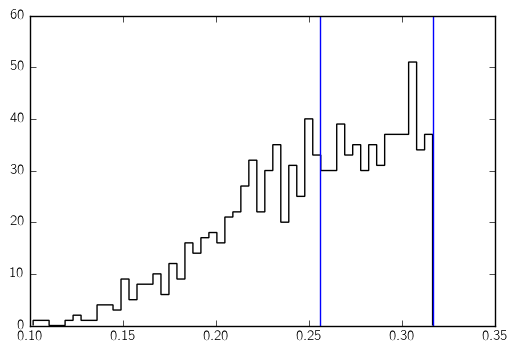

In [322]:
plt.hist(rho, 50, histtype="step", color="k")
plt.gca().axvline(eps)
plt.gca().axvline(np.percentile(rho, 50));